In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
import itertools
import math

sns.set()
%matplotlib inline

df = pd.read_csv("datasets/nsdata1.txt",  delimiter=r"\s+")

AMSTERDAM = 1
ROTTERDAM = 2
ROOSENDAAL = 3
VLISSINGEN = 4

type_3_train = (38, 163)
type_4_train = (65, 218)

df.head(10)

,train_number,from,to,departure_time,arrival_time,first_class,second_class
0,2123,2,3,700,740,4,58
1,2123,3,4,743,838,14,328
2,2127,1,2,648,755,47,340
3,2127,2,3,801,841,35,272
4,2127,3,4,843,938,19,181
5,2131,1,2,755,858,100,616
6,2131,2,3,902,941,52,396
7,2131,3,4,943,1038,27,270
8,2135,1,2,856,958,61,407
9,2135,2,3,1003,1043,41,364


In [136]:
def to_minutes_past_midnight(time: int) -> int:
    """Converts the time as used in the data-files to minutes past midnight.
    """

    assert type(time) == int, "The time must be an integer!"

    hours = time // 100
    minutes = time % 100

    return 60*hours + minutes

In [137]:
df['departure_time'] = df['departure_time'].map(to_minutes_past_midnight)
df['arrival_time'] = df['arrival_time'].map(to_minutes_past_midnight)

In [138]:
df.head(10)

,train_number,from,to,departure_time,arrival_time,first_class,second_class
0,2123,2,3,420,460,4,58
1,2123,3,4,463,518,14,328
2,2127,1,2,408,475,47,340
3,2127,2,3,481,521,35,272
4,2127,3,4,523,578,19,181
5,2131,1,2,475,538,100,616
6,2131,2,3,542,581,52,396
7,2131,3,4,583,638,27,270
8,2135,1,2,536,598,61,407
9,2135,2,3,603,643,41,364


In [139]:
def min_trains(row:pd.Series, train_type: Tuple[int, int])->  int:
    """Finds the minimum number of trains needed in row.
    """
    
    min_first_class = row[5]/train_type[0]
    min_second_class = row[6]/train_type[1]

    min_trains = math.ceil(max(min_first_class, min_second_class))

    return min_trains

In [140]:
def trains_at_t(schedule: pd.DataFrame, train_type: Tuple[int, int]) -> pd.DataFrame:
    """Creates a new DataFrame whoes index is number of minutes past midnight and 
    for each minute contains the minimum number of trains needed to serve the schedule.
    """
    
    df = pd.DataFrame(np.zeros((60*24, 1)))
    df.columns = ['number of trains']

    for index, row in schedule.iterrows():
        start = row[3]
        stop = row[4]
        
        
        df.loc[start:stop, 'number of trains'] += min_trains(row, train_type=train_type)

    return df

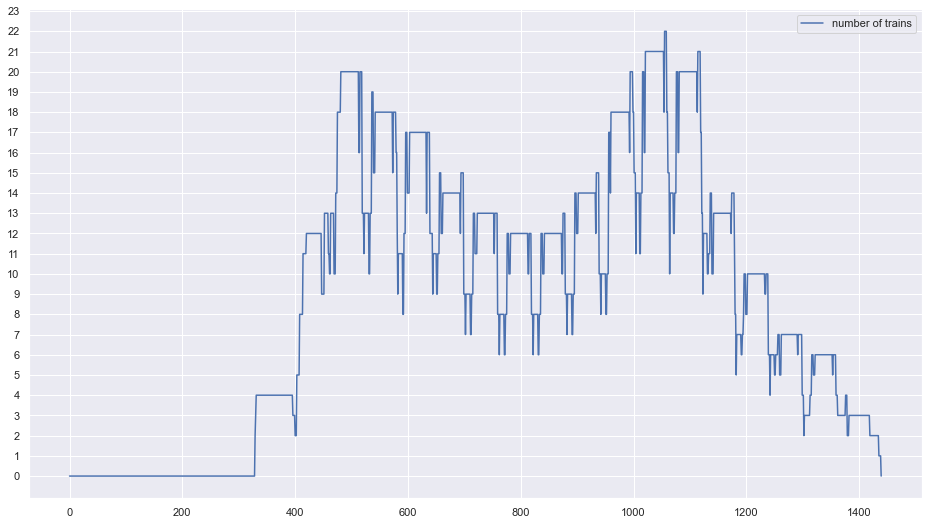

In [141]:
ax = trains_at_t(df, type_3_train).plot(figsize=(16,9))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(range(24));

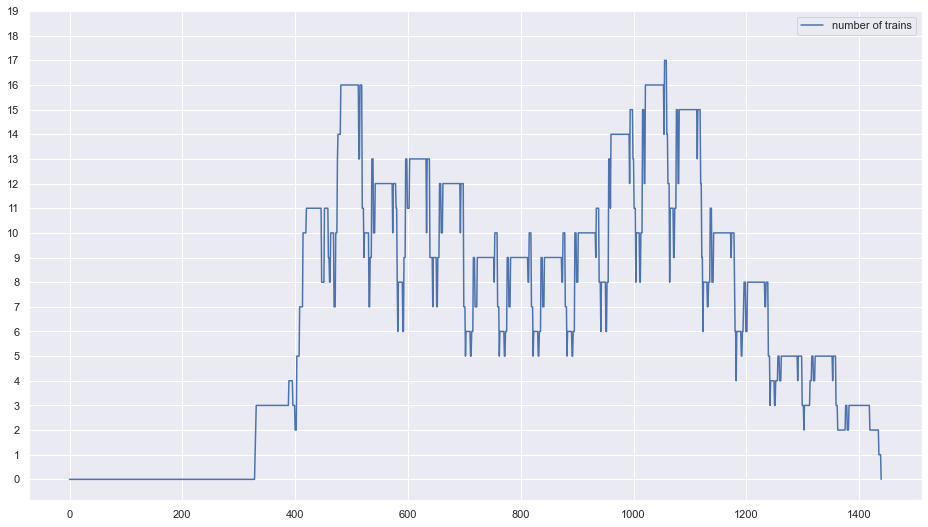

In [142]:
ax = trains_at_t(df, type_4_train).plot(figsize=(16,9))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(range(20));

In [143]:
def create_trains_dict(schedulce: pd.DataFrame) -> dict:
    """Creates a dict with an entry for every train_number in schedule
    with the train_number as key and that trains schedule as value.
    """

    trains = dict()

    for index, row in schedulce.iterrows():
        if row[0] in trains:
            trains[row[0]] = pd.concat([trains[row[0]], pd.DataFrame(row).T])
        else:
            trains[row[0]] = pd.DataFrame(row).T
    
    return trains

In [144]:
colors = ['b', 'r', 'k', 'g', 'm', 'c']
color_cycle = itertools.cycle(colors)

class Train:
    def __init__(self, train_number: int, schedule: pd.DataFrame, ax:plt.Axes) -> None:
        """Create train object based on the train number and its schedule.
        """
        
        self.ax = ax
        self.train_number = train_number
        self._schedule = schedule
        df = pd.DataFrame()
        df['time'] = pd.concat([schedule['departure_time'], schedule['arrival_time']])
        df['place'] = pd.concat([schedule['from'], schedule['to']])
        self.schedule = df.sort_values(by='time').reset_index()


    def plot(self, train_type) -> None:
        """Plot the space time graph of the train line
        """
        col = next(color_cycle)

        ax=self.ax
            
        self.schedule.plot(kind='line', x='time', y='place', ax=ax, color=col) 
         
        for index, row in self._schedule.iterrows():
            offset_t = 10
            offset_p = 0
            place = row[1] - (row[1] - row[2])/4 + offset_p
            time = row[3] - (row[3] - row[4])/4 + offset_t

            ax.text(time, place, f'{row[5]}\n{row[6]}')
            ax.text(time, place-0.1, str(min_trains(row, train_type)), color='r')


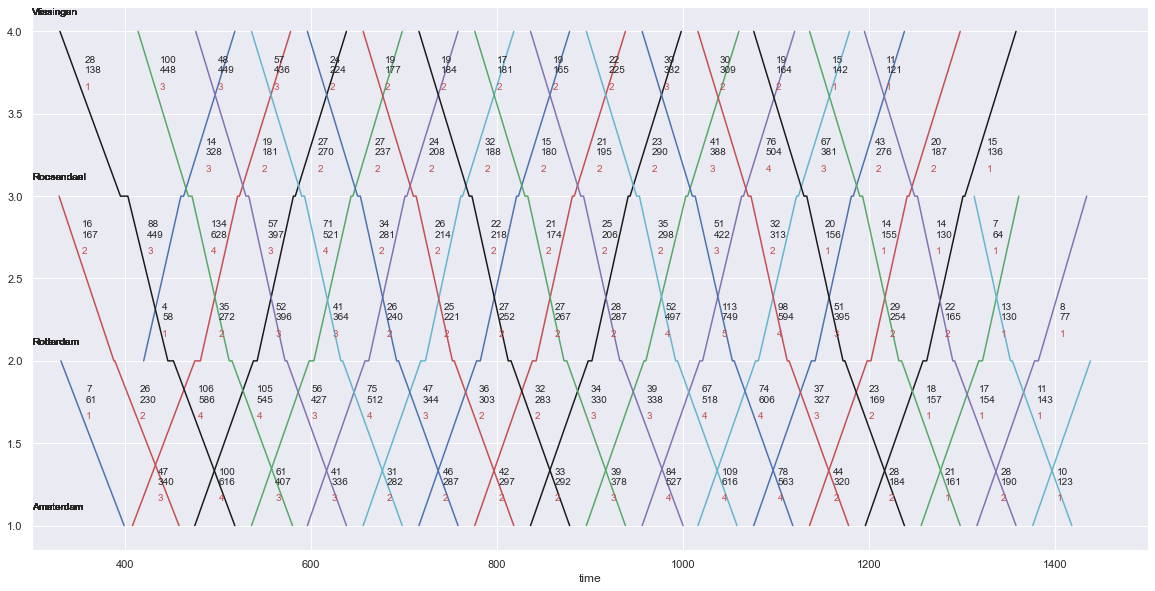

In [145]:
class VisualizeSchedule:
    def __init__(self, trains_to_visualize: dict) -> None:
        """Setup the schedule that needs to be visualized.
        """

        self.trains = trains_to_visualize

    def visualize(self, train_type) -> None:
        """Show the space-time plot of the train schedule.
        """

        fig, ax = plt.subplots(figsize=(20, 10))
        ax.set_xlim(300, 1500)

        for key, value in self.trains.items():
            train = Train(key, value, ax)
            train.plot(train_type=train_type)
            ax.text(300, AMSTERDAM + 0.1, 'Amsterdam')
            ax.text(300, ROTTERDAM + 0.1, 'Rotterdam')
            ax.text(300, ROOSENDAAL + 0.1, 'Roosendaal')
            ax.text(300, VLISSINGEN + 0.1, 'Vlissingen')
            plt.legend().remove()

trains = create_trains_dict(df)
trains_subset = dict(itertools.islice(trains.items(), 10))

viz = VisualizeSchedule(trains)
viz.visualize(train_type=type_3_train)
plt.savefig('output.pdf')